In [151]:
import torch
import torch_geometric
import torch.nn as nn
from e3nn.o3 import FullyConnectedTensorProduct
import numpy as np
import matplotlib.pyplot as plt

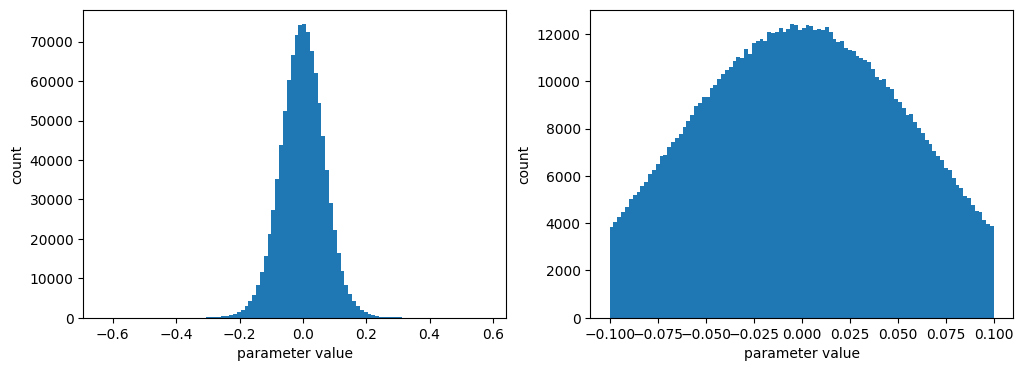

In [147]:
def inspect_distr(seq_num):
    """
    Inspect the distribution of all trained parameters.
    
    ------------
    seq_num: str or int
        the 5-digit sequence string representing a trained model
    """

    # (!) load trained parameters
    trained_paras = torch.load('saved models/segnn_qm9_alpha_' + str(seq_num) + '_cuda:0.pt')

    tensor_collection = []
    for k, v in trained_paras.items():
        if "tp.weight" in k:
            tensor_collection.append(v)

    all_entries = []
    for i, tensor in enumerate(tensor_collection):
        all_entries.extend(tensor.flatten().tolist())

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(all_entries, bins = 100)
    plt.xlabel("parameter value")
    plt.ylabel("count")

    plt.subplot(1, 2, 2)
    plt.hist(all_entries, bins = 100, range=(-0.1, 0.1))
    plt.xlabel("parameter value")
    plt.ylabel("count")
    
    plt.show()


    
inspect_distr(33525)

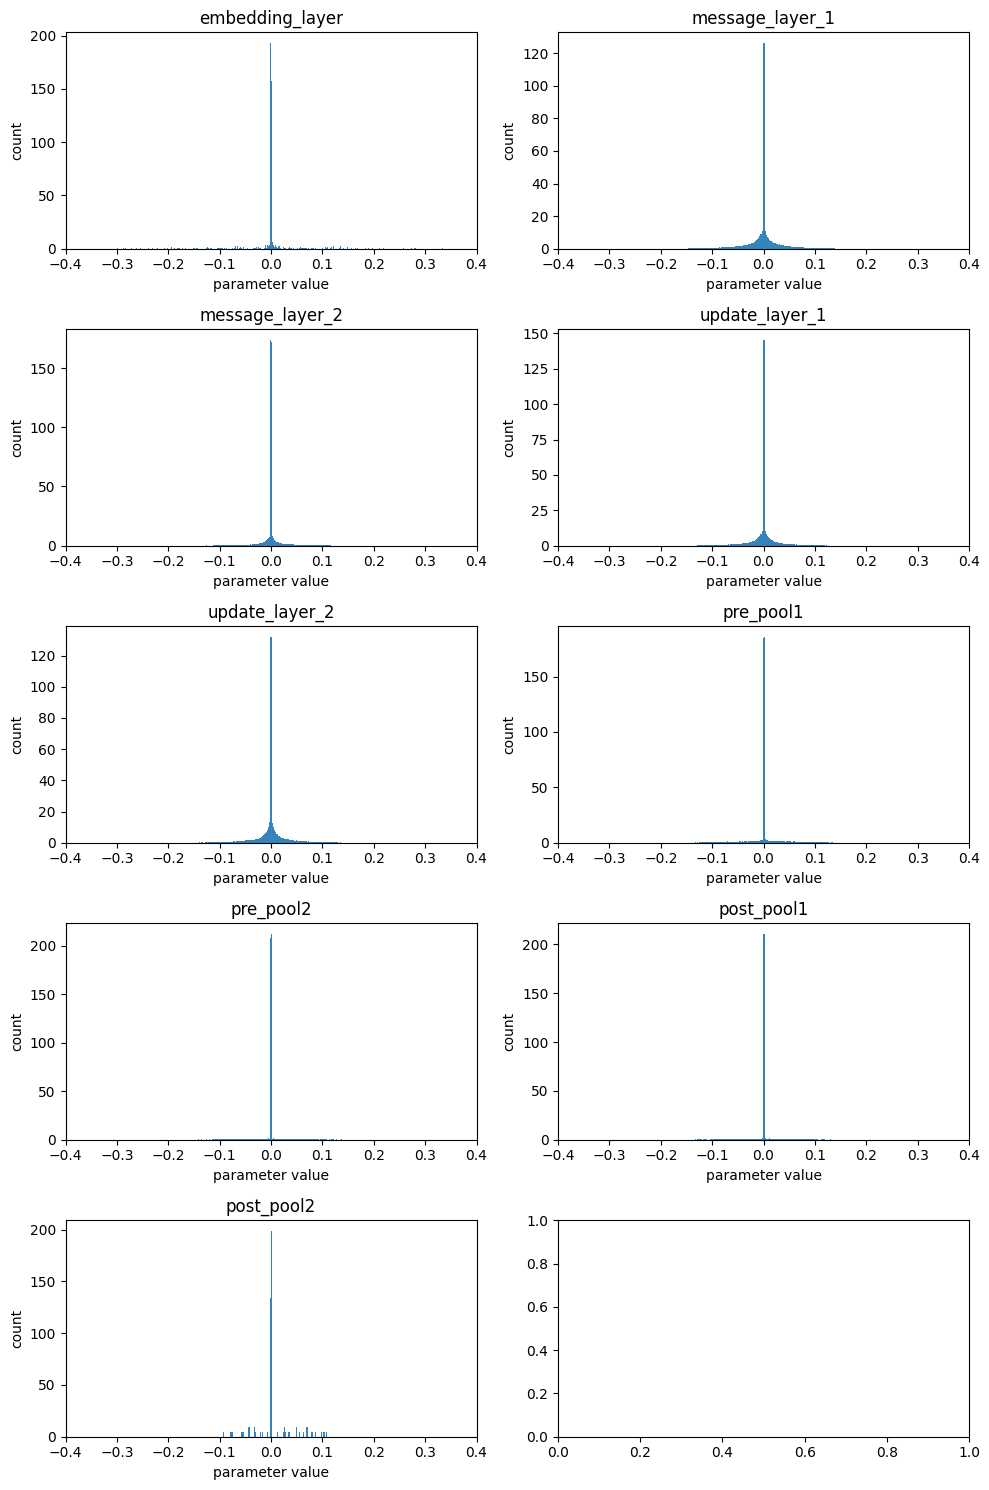

In [162]:
def inspect_layer_distr(seq_num):
    """
    Inspect the distribution of trained parameters within each type of layers separately.
    
    ------------
    seq_num: str or int
        the 6-digit sequence string representing a trained model
    """
    
    # (!) load trained parameters
    trained_paras = torch.load('saved models/segnn_qm9_alpha_' + str(seq_num) + '_cuda:0.pt')
    
    layer_weight_dict = {}
    for k, v in trained_paras.items():
        if "tp.weight" in k:
            layer_weight_dict[k] = v
    
    # check layer names
    # print(layer_weight_dict.keys(), end='\n')

    pooled_layer_weight_dict = {'embedding_layer':[], 'message_layer_1':[], 'message_layer_2':[], 
                                'update_layer_1':[], 'update_layer_2':[], 'pre_pool1':[], 'pre_pool2':[],
                                'post_pool1':[], 'post_pool2':[]}
    for k, v in layer_weight_dict.items():
        for layer_name in pooled_layer_weight_dict.keys():
            if layer_name in k:
                pooled_layer_weight_dict[layer_name].extend(v.flatten().tolist())
    
    num_rows = len(pooled_layer_weight_dict) // 2
    if len(pooled_layer_weight_dict) % 2 != 0:
        num_rows += 1
    
    fig, axs = plt.subplots(num_rows, 2, figsize=(10, 3 * num_rows), tight_layout=True)
    
    bin_width = 0.002
    # add -1 and 1 to collect all values outside (-4, 4)
    bin_edges = [-1] + list(np.arange(-0.4, 0.4 + bin_width, bin_width)) + [1]
    
    for idx, (key, value) in enumerate(pooled_layer_weight_dict.items()):
        row = idx // 2
        col = idx % 2
        axs[row, col].hist(value, density=True, bins=bin_edges, alpha=0.9)
        axs[row, col].set_xlim(-0.4, 0.4)
        axs[row, col].set_xlabel('parameter value')
        axs[row, col].set_ylabel('relative frequency')
        axs[row, col].set_title(key)
        
    plt.show()
    

    
inspect_layer_distr(92158)

In [106]:
"""A quick example that illustrates the main idea for `inspect_type_distr` below."""
from e3nn.o3 import Irreps

class O3TensorProduct(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        self.tp = FullyConnectedTensorProduct(
            irreps_in1=Irreps('1x1e + 1x0e'),
            irreps_in2=Irreps('1x1e + 1x0e'),
            irreps_out=Irreps('2x0e + 3x1e'),
            internal_weights = True,
            shared_weights = True
        )
        print(self.tp)

layer1 = O3TensorProduct()
print(list(layer1.named_parameters()))
print('\n')
    
for w in layer1.tp.weight_views(yield_instruction=True):
    print(w[1], w[2], sep='\n')
    print('\n')

print(layer1.tp.irreps_out[w[1][2]].ir.l)

FullyConnectedTensorProduct(1x1e+1x0e x 1x1e+1x0e -> 2x0e+3x1e | 13 paths | 13 weights)
[('tp.weight', Parameter containing:
tensor([ 0.9983, -0.3599, -0.0995, -0.4984,  0.0993,  0.7539,  1.0196, -1.3359,
         0.8073, -0.0099, -0.5479, -0.1661, -1.1992], requires_grad=True))]


Instruction(i_in1=0, i_in2=0, i_out=0, connection_mode='uvw', has_weight=True, path_weight=0.7071067811865476, path_shape=(1, 1, 2))
tensor([[[ 0.9983, -0.3599]]], grad_fn=<ViewBackward0>)


Instruction(i_in1=0, i_in2=0, i_out=1, connection_mode='uvw', has_weight=True, path_weight=1.0, path_shape=(1, 1, 3))
tensor([[[-0.0995, -0.4984,  0.0993]]], grad_fn=<ViewBackward0>)


Instruction(i_in1=0, i_in2=1, i_out=1, connection_mode='uvw', has_weight=True, path_weight=1.0, path_shape=(1, 1, 3))
tensor([[[ 0.7539,  1.0196, -1.3359]]], grad_fn=<ViewBackward0>)


Instruction(i_in1=1, i_in2=0, i_out=1, connection_mode='uvw', has_weight=True, path_weight=1.0, path_shape=(1, 1, 3))
tensor([[[ 0.8073, -0.0099, -0.5479]]]

Determined irrep type: 36x0e+36x1o+36x2e


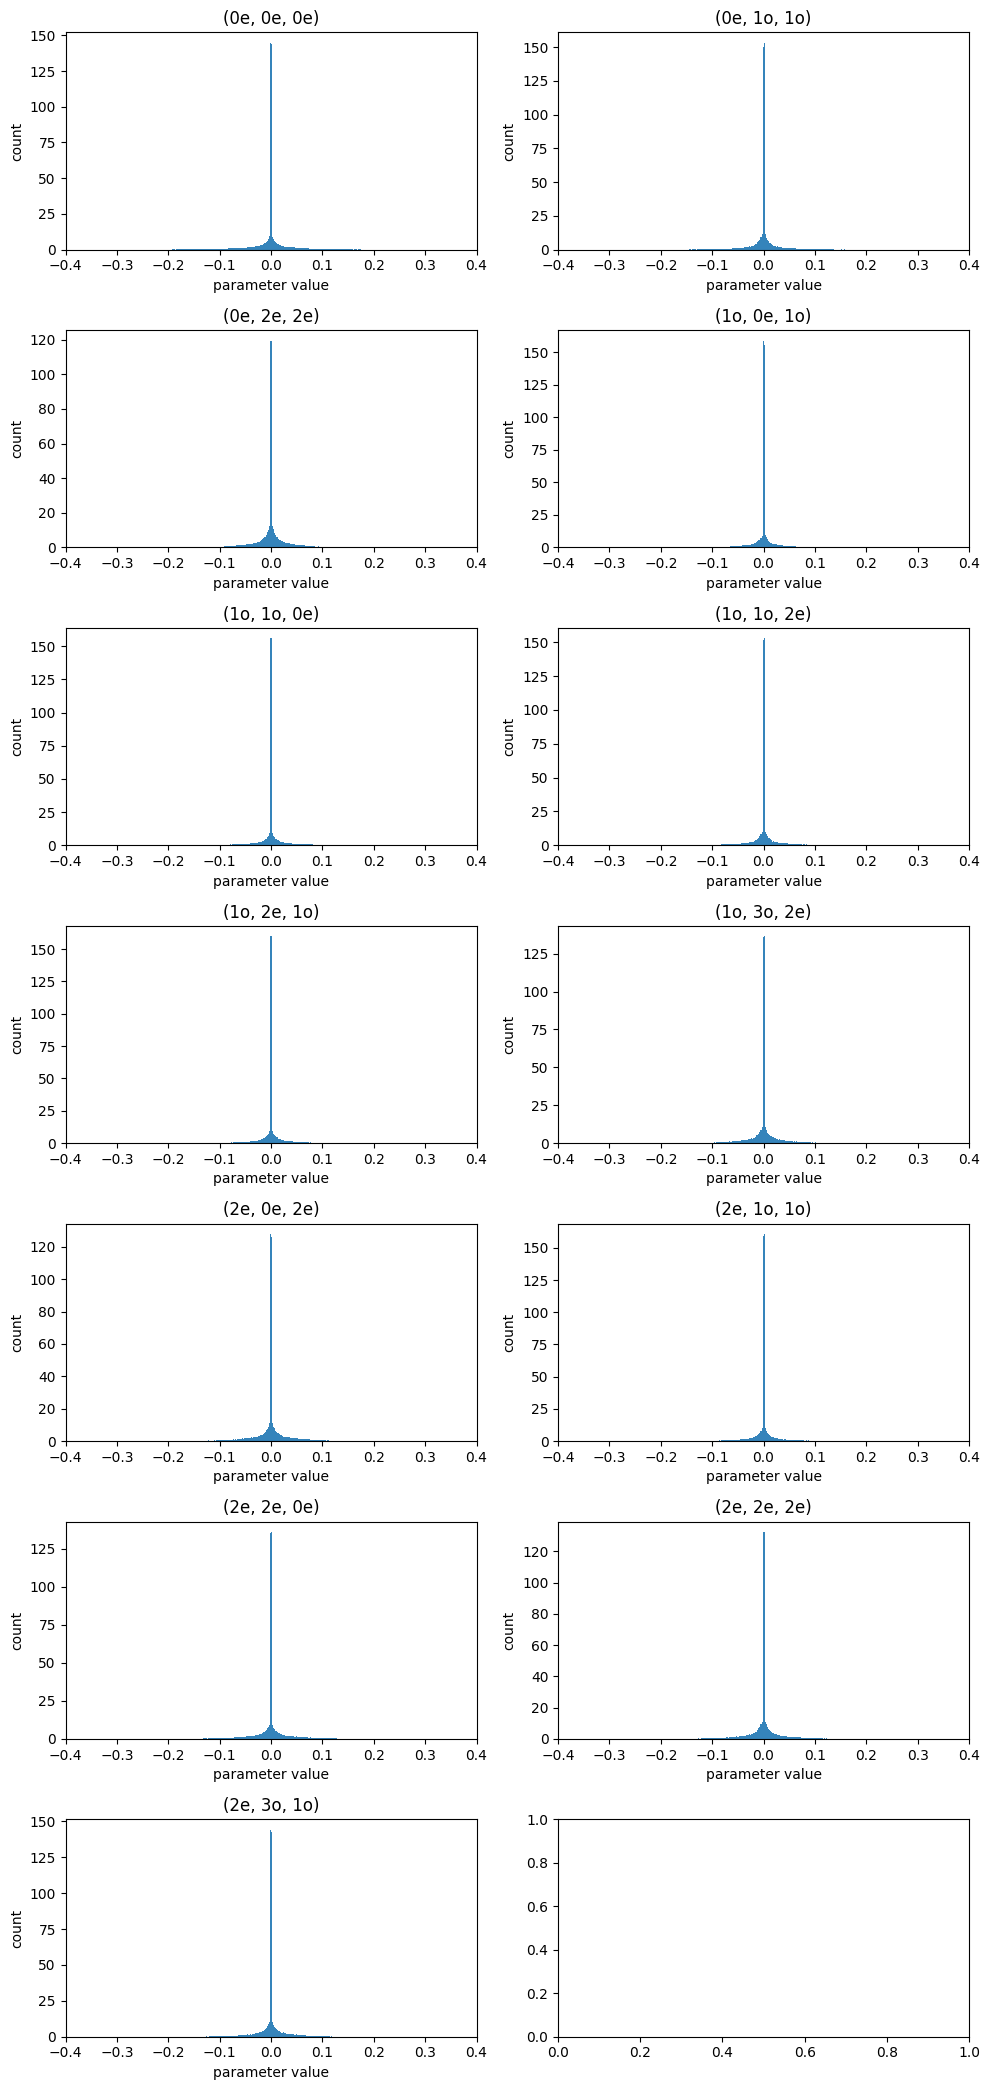

In [163]:
from e3nn.o3 import Irreps
from models.segnn.segnn import SEGNN
from models.balanced_irreps import WeightBalancedIrreps

def inspect_type_distr(seq_num):
    """
    Inspect the distribution of trained parameters separately for each distinct (l_in1, l_in2, l_out) tuple.
    
    ------------
    seq_num: str or int
        the 6-digit sequence string representing a trained model
    """
    
    # (!) load trained parameters
    trained_paras = torch.load('saved models/segnn_qm9_alpha_' + str(seq_num) + '_cuda:0.pt')
    
    # check which layers contain tp.weight
    # layer_names = []
    # for k, v in trained_paras.items():
    #     if k.endswith(".tp.weight"):
    #         layer_names.append(k[:-len(".tp.weight")])
    # print(layer_names)
    
    # recreate parser argument 
    lmax_attr = 3
    lmax_h = 2
    hidden_features = 128
    layers = 7
    norm = "instance"
    pool = "avg"
    task = "graph"
    
    # recreate model input
    input_irreps = Irreps("5x0e")
    output_irreps = Irreps("1x0e")
    edge_attr_irreps = Irreps.spherical_harmonics(lmax_attr)
    node_attr_irreps = Irreps.spherical_harmonics(lmax_attr)
    additional_message_irreps = Irreps("1x0e")
    hidden_irreps = WeightBalancedIrreps(
            Irreps("{}x0e".format(hidden_features)), node_attr_irreps, sh=True, lmax=lmax_h)
    
    # create an empty model of conformable shape
    model = SEGNN(input_irreps,
                  hidden_irreps,
                  output_irreps,
                  edge_attr_irreps,
                  node_attr_irreps,
                  num_layers=layers,
                  norm=norm,
                  pool=pool,
                  task=task,
                  additional_message_irreps=additional_message_irreps)
    
    # load model using trained parameters
    model.load_state_dict(trained_paras)
    
    # record all the layers that contain tp.weight
    layers = [model.embedding_layer, model.pre_pool1, model.pre_pool2,
              model.post_pool1, model.post_pool2]
    
    for segnn_layer in model.layers:
        layers.append(segnn_layer.message_layer_1)
        layers.append(segnn_layer.message_layer_2)
        layers.append(segnn_layer.update_layer_1)
        layers.append(segnn_layer.update_layer_2)
    
    # print(layers)
    
    # categorize entries based on their in_out_type
    in_out_type_weight_dict = {}
    for layer in layers:
        for w in layer.tp.weight_views(yield_instruction=True):
            # w[1] is instruction; w[2] is weight_view
            # the first three entries of instruction are indices of the corresponding irreps used in tp: (in1, in2, out)
            # layer.tp.irreps_in1[w[1][0]] return an MulIr object (e.g. 2x1e) and .ir obtains type with parity
            l_in1 = layer.tp.irreps_in1[w[1][0]].ir
            l_in2 = layer.tp.irreps_in2[w[1][1]].ir
            l_out = layer.tp.irreps_out[w[1][2]].ir
            in_out_tuple = (l_in1, l_in2, l_out)
            
            if in_out_tuple not in in_out_type_weight_dict.keys():
                in_out_type_weight_dict[in_out_tuple] = []
            
            in_out_type_weight_dict[in_out_tuple].extend(w[2].flatten().tolist())
    
    # print(in_out_type_weight_dict.keys())
    
    # arrange plots into two columns
    num_rows = len(in_out_type_weight_dict) // 2
    if len(in_out_type_weight_dict) % 2 != 0:
        num_rows += 1
    
    fig, axs = plt.subplots(num_rows, 2, figsize=(10, 3 * num_rows), tight_layout=True)
    
    bin_width = 0.002
    # add -1 and 1 to collect all values outside (-4, 4)
    bin_edges = [-1] + list(np.arange(-0.4, 0.4 + bin_width, bin_width)) + [1]
    
    for idx, (key, value) in enumerate(in_out_type_weight_dict.items()):
        row = idx // 2
        col = idx % 2
        axs[row, col].hist(value, density=True, bins=bin_edges, alpha=0.9)
        axs[row, col].set_xlim(-0.4, 0.4)
        axs[row, col].set_xlabel('parameter value')
        axs[row, col].set_ylabel('relative frequency')
        axs[row, col].set_title(key)

    plt.show()
    
    
    
inspect_type_distr(92158)